## Multi-model Creation for American Soccer Game Predictions
#### Author: Mason Langer
##### Last Updated: Sept. 3, 2025
This notebook explores three different methods of regressing to an expected goals (XG) value for players based on rolling sums/averages with an Artificial Neural Network (ANN), a Random Forest (RF), and XGBoost. Along with these regressors, classifiers based on the same methods (ANN, RF, XGBoost) are created to determine the efficacy of using XG projections along with game context to predict the likelihood of a certain result (win, loss, or draw).

By the end of this notebook, the nine combinations of the three regressors and three classifiers, as well as various polling ensemble models, will be analyzed for their performance. 

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import imblearn
import xgboost
from keras_tuner import RandomSearch
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, log_loss, mean_squared_error, mean_absolute_error, f1_score, confusion_matrix, accuracy_score
pd.set_option('display.max_columns', None)

In [2]:
## NWSL data was primarily gathered from American Soccer Analysis data over the past three full seasons.
## Rolling features such as rolling sums and averages over the previous 2 and 5 games were calculated in the ASAData.Rmd and
## ASAFeatureEngineering.Rmd R Markdown notebooks found in the /data_collection folder.
nwsl = pd.read_csv('./data/NWSL_XG_ANN_Data.csv')
nwsl.head(5)

,season_name,matchday,opponent_id,game_id,player_id,height,age,team_id,home_score,away_score,is_home,general_position,shots_sp,shots_on_target_sp,goals_sp,xgoals_sp,xplace_sp,goals_minusgoals_sp,key_passes_sp,primary_assists_sp,xassists_sp,primary_assists_minusassists_sp,goals_plus_primary_assists_sp,xgoals_plusassists_sp,points_added_sp,xpoints_added_sp,shots_c,shots_on_target_c,goals_c,xgoals_c,xplace_c,goals_minusgoals_c,key_passes_c,primary_assists_c,xassists_c,primary_assists_minusassists_c,goals_plus_primary_assists_c,xgoals_plusassists_c,points_added_c,xpoints_added_c,shots_fk,shots_on_target_fk,goals_fk,xgoals_fk,xplace_fk,goals_minusgoals_fk,key_passes_fk,primary_assists_fk,xassists_fk,primary_assists_minusassists_fk,goals_plus_primary_assists_fk,xgoals_plusassists_fk,points_added_fk,xpoints_added_fk,shots_pen,shots_on_target_pen,goals_pen,xgoals_pen,xplace_pen,goals_minusgoals_pen,key_passes_pen,primary_assists_pen,xassists_pen,primary_assists_minusassists_pen,goals_plus_primary_assists_pen,xgoals_plusassists_pen,points_added_pen,xpoints_added_pen,shots_fb,shots_on_target_fb,goals_fb,xgoals_fb,xplace_fb,goals_minusgoals_fb,key_passes_fb,primary_assists_fb,xassists_fb,primary_assists_minusassists_fb,goals_plus_primary_assists_fb,xgoals_plusassists_fb,points_added_fb,xpoints_added_fb,shots_reg,shots_on_target_reg,goals_reg,xgoals_reg,xplace_reg,goals_minusgoals_reg,key_passes_reg,primary_assists_reg,xassists_reg,primary_assists_minusassists_reg,goals_plus_primary_assists_reg,xgoals_plusassists_reg,points_added_reg,xpoints_added_reg,attempted_passes_att,pass_completion_percentage_att,xpass_completion_percentage_att,passes_completed_over_pected_att,passes_completed_over_pected_p100_att,avg_distance_yds_att,avg_vertical_distance_yds_att,share_team_touches_att,attempted_passes_mid,pass_completion_percentage_mid,xpass_completion_percentage_mid,passes_completed_over_pected_mid,passes_completed_over_pected_p100_mid,avg_distance_yds_mid,avg_vertical_distance_yds_mid,share_team_touches_mid,attempted_passes_def,pass_completion_percentage_def,xpass_completion_percentage_def,passes_completed_over_pected_def,passes_completed_over_pected_p100_def,avg_distance_yds_def,avg_vertical_distance_yds_def,share_team_touches_def,date_time_utc,extra_time,result,running_sum_goals_reg_n5,running_sum_assts_reg_n5,running_avg_xgoals_reg_n5,running_avg_xassists_reg_n5,running_avg_keyp_reg_n5,running_sum_goals_fb_n5,running_sum_assts_fb_n5,running_avg_xgoals_fb_n5,running_avg_xassists_fb_n5,running_avg_keyp_fb_n5,running_sum_goals_pen_n5,running_avg_xgoals_pen_n5,running_sum_goals_fk_n5,running_sum_assts_fk_n5,running_avg_xgoals_fk_n5,running_avg_xassists_fk_n5,running_avg_keyp_fk_n5,running_sum_goals_c_n5,running_sum_assts_c_n5,running_avg_xgoals_c_n5,running_avg_xassists_c_n5,running_avg_keyp_c_n5,running_sum_goals_sp_n5,running_sum_assts_sp_n5,running_avg_xgoals_sp_n5,running_avg_xassists_sp_n5,running_avg_keyp_sp_n5,running_avg_attempted_pass_att_n5,running_avg_pass_over_expected_att_n2,running_avg_share_touches_att_n5,running_avg_attempted_pass_mid_n5,running_avg_pass_over_expected_mid_n5,running_avg_share_touches_mid_n5,running_avg_attempted_pass_def_n5,running_avg_pass_over_expected_def_n5,running_avg_share_touches_def_n5,running_num_et_n5,running_num_pts_n5,running_sum_goals_reg_n2,running_sum_assts_reg_n2,running_avg_xgoals_reg_n2,running_avg_xassists_reg_n2,running_avg_keyp_reg_n2,running_sum_goals_fb_n2,running_sum_assts_fb_n2,running_avg_xgoals_fb_n2,running_avg_xassists_fb_n2,running_avg_keyp_fb_n2,running_sum_goals_pen_n2,running_avg_xgoals_pen_n2,running_sum_goals_fk_n2,running_sum_assts_fk_n2,running_avg_xgoals_fk_n2,running_avg_xassists_fk_n2,running_avg_keyp_fk_n2,running_sum_goals_c_n2,running_sum_assts_c_n2,running_avg_xgoals_c_n2,running_avg_xassists_c_n2,running_avg_keyp_c_n2,running_sum_goals_sp_n2,running_sum_assts_sp_n2,running_avg_xgoals_sp_n2,running_avg_xassists_sp_n2,running_avg_keyp_sp_n2,running_avg_attempted_pass_att_

In [3]:
df = nwsl.copy()
df['xgoals'] = df.apply(lambda x: sum([x.xgoals_sp, x.xgoals_c, x.xgoals_fk, x.xgoals_pen, x.xgoals_fb, x.xgoals_reg]), axis=1)
take_cols = list(df.loc[:,'running_sum_goals_reg_n5':].columns)
take_cols.insert(0, 'height')
df = df.loc[:, take_cols]
df.head(5)

,height,running_sum_goals_reg_n5,running_sum_assts_reg_n5,running_avg_xgoals_reg_n5,running_avg_xassists_reg_n5,running_avg_keyp_reg_n5,running_sum_goals_fb_n5,running_sum_assts_fb_n5,running_avg_xgoals_fb_n5,running_avg_xassists_fb_n5,running_avg_keyp_fb_n5,running_sum_goals_pen_n5,running_avg_xgoals_pen_n5,running_sum_goals_fk_n5,running_sum_assts_fk_n5,running_avg_xgoals_fk_n5,running_avg_xassists_fk_n5,running_avg_keyp_fk_n5,running_sum_goals_c_n5,running_sum_assts_c_n5,running_avg_xgoals_c_n5,running_avg_xassists_c_n5,running_avg_keyp_c_n5,running_sum_goals_sp_n5,running_sum_assts_sp_n5,running_avg_xgoals_sp_n5,running_avg_xassists_sp_n5,running_avg_keyp_sp_n5,running_avg_attempted_pass_att_n5,running_avg_pass_over_expected_att_n2,running_avg_share_touches_att_n5,running_avg_attempted_pass_mid_n5,running_avg_pass_over_expected_mid_n5,running_avg_share_touches_mid_n5,running_avg_attempted_pass_def_n5,running_avg_pass_over_expected_def_n5,running_avg_share_touches_def_n5,running_num_et_n5,running_num_pts_n5,running_sum_goals_reg_n2,running_sum_assts_reg_n2,running_avg_xgoals_reg_n2,running_avg_xassists_reg_n2,running_avg_keyp_reg_n2,running_sum_goals_fb_n2,running_sum_assts_fb_n2,running_avg_xgoals_fb_n2,running_avg_xassists_fb_n2,running_avg_keyp_fb_n2,running_sum_goals_pen_n2,running_avg_xgoals_pen_n2,running_sum_goals_fk_n2,running_sum_assts_fk_n2,running_avg_xgoals_fk_n2,running_avg_xassists_fk_n2,running_avg_keyp_fk_n2,running_sum_goals_c_n2,running_sum_assts_c_n2,running_avg_xgoals_c_n2,running_avg_xassists_c_n2,running_avg_keyp_c_n2,running_sum_goals_sp_n2,running_sum_assts_sp_n2,running_avg_xgoals_sp_n2,running_avg_xassists_sp_n2,running_avg_keyp_sp_n2,running_avg_attempted_pass_att_n2,running_avg_share_touches_att_n2,running_avg_attempted_pass_mid_n2,running_avg_pass_over_expected_mid_n2,running_avg_share_touches_mid_n2,running_avg_attempted_pass_def_n2,running_avg_pass_over_expected_def_n2,running_avg_share_touches_def_n2,running_num_et_n2,running_num_pts_n2,running_avg_over_pos_avg_xgoals_reg_n5,running_avg_over_pos_avg_xassists_reg_n5,running_avg_over_pos_avg_keyp_reg_n5,running_avg_over_pos_avg_xgoals_fb_n5,running_avg_over_pos_avg_xassists_fb_n5,running_avg_over_pos_avg_keyp_fb_n5,running_avg_over_pos_avg_xgoals_pen_n5,running_avg_over_pos_avg_xgoals_c_n5,running_avg_over_pos_avg_xassists_c_n5,running_avg_over_pos_avg_keyp_c_n5,running_avg_over_pos_avg_xgoals_fk_n5,running_avg_over_pos_avg_xassists_fk_n5,running_avg_over_pos_avg_keyp_fk_n5,running_avg_over_pos_avg_xgoals_sp_n5,running_avg_over_pos_avg_xassists_sp_n5,running_avg_over_pos_avg_keyp_sp_n5,running_avg_over_pos_avg_share_touches_att_n5,running_avg_over_pos_avg_share_touches_mid_n5,running_avg_over_pos_avg_share_touches_def_n5,running_avg_over_pos_avg_xgoals_reg_n2,running_avg_over_pos_avg_xassists_reg_n2,running_avg_over_pos_avg_keyp_reg_n2,running_avg_over_pos_avg_xgoals_fb_n2,running_avg_over_pos_avg_xassists_fb_n2,running_avg_over_pos_avg_keyp_fb_n2,running_avg_over_pos_avg_xgoals_pen_n2,running_avg_over_pos_avg_xgoals_c_n2,running_avg_over_pos_avg_xassists_c_n2,running_avg_over_pos_avg_keyp_c_n2,running_avg_over_pos_avg_xgoals_fk_n2,running_avg_over_pos_avg_xassists_fk_n2,running_avg_over_pos_avg_keyp_fk_n2,running_avg_over_pos_avg_xgoals_sp_n2,running_avg_over_pos_avg_xassists_sp_n2,running_avg_over_pos_avg_keyp_sp_n2,running_avg_over_pos_avg_share_touches_att_n2,running_avg_over_pos_avg_share_touches_mid_n2,running_avg_over_pos_avg_share_touches_def_n2,running_opp_sum_goals_reg_n5,running_opp_sum_xgoals_reg_n5,running_opp_sum_xassists_reg_n5,running_opp_sum_goals_fb_n5,running_opp_sum_xgoals_fb_n5,running_opp_sum_xassists_fb_n5,running_opp_sum_goals_pen_n5,running_opp_sum_xgoals_pen_n5,running_opp_sum_goals_c_n5,running_opp_sum_avg_xgoals_c_n5,running_opp_sum_avg_xassists_c_n5,running_opp_sum_goals_fk_n5,running_opp_sum_avg_xgoals_fk_n5,running_opp_sum_xassists_fk_n5,running_opp_sum_goals_sp_n5,running_opp_sum_xgoals_sp_n5,running_opp_sum_xass

### 1. Artificial Neural Network Regressor
The following section details the creation of an ANN-based regression model for a player's XG for a given game based on their past performance (prev. 2 games, prev. 5 games), their past performance over position average, their opponent's past performance and other teams' performance vs. the opponent over the same timeframe.

While ANN regressors aren't traditionally used for such an application, the combination of previous literature utilizing ANNs for soccer-specific data and ANNs' proficiency with multi-dimensional datasets was the reason for why this model was selected as one of three for this survey.

In [5]:
mms = MinMaxScaler()
df_normalized = pd.DataFrame(mms.fit_transform(df), columns=df.columns)
df_normalized.head(5)

,height,running_sum_goals_reg_n5,running_sum_assts_reg_n5,running_avg_xgoals_reg_n5,running_avg_xassists_reg_n5,running_avg_keyp_reg_n5,running_sum_goals_fb_n5,running_sum_assts_fb_n5,running_avg_xgoals_fb_n5,running_avg_xassists_fb_n5,running_avg_keyp_fb_n5,running_sum_goals_pen_n5,running_avg_xgoals_pen_n5,running_sum_goals_fk_n5,running_sum_assts_fk_n5,running_avg_xgoals_fk_n5,running_avg_xassists_fk_n5,running_avg_keyp_fk_n5,running_sum_goals_c_n5,running_sum_assts_c_n5,running_avg_xgoals_c_n5,running_avg_xassists_c_n5,running_avg_keyp_c_n5,running_sum_goals_sp_n5,running_sum_assts_sp_n5,running_avg_xgoals_sp_n5,running_avg_xassists_sp_n5,running_avg_keyp_sp_n5,running_avg_attempted_pass_att_n5,running_avg_pass_over_expected_att_n2,running_avg_share_touches_att_n5,running_avg_attempted_pass_mid_n5,running_avg_pass_over_expected_mid_n5,running_avg_share_touches_mid_n5,running_avg_attempted_pass_def_n5,running_avg_pass_over_expected_def_n5,running_avg_share_touches_def_n5,running_num_et_n5,running_num_pts_n5,running_sum_goals_reg_n2,running_sum_assts_reg_n2,running_avg_xgoals_reg_n2,running_avg_xassists_reg_n2,running_avg_keyp_reg_n2,running_sum_goals_fb_n2,running_sum_assts_fb_n2,running_avg_xgoals_fb_n2,running_avg_xassists_fb_n2,running_avg_keyp_fb_n2,running_sum_goals_pen_n2,running_avg_xgoals_pen_n2,running_sum_goals_fk_n2,running_sum_assts_fk_n2,running_avg_xgoals_fk_n2,running_avg_xassists_fk_n2,running_avg_keyp_fk_n2,running_sum_goals_c_n2,running_sum_assts_c_n2,running_avg_xgoals_c_n2,running_avg_xassists_c_n2,running_avg_keyp_c_n2,running_sum_goals_sp_n2,running_sum_assts_sp_n2,running_avg_xgoals_sp_n2,running_avg_xassists_sp_n2,running_avg_keyp_sp_n2,running_avg_attempted_pass_att_n2,running_avg_share_touches_att_n2,running_avg_attempted_pass_mid_n2,running_avg_pass_over_expected_mid_n2,running_avg_share_touches_mid_n2,running_avg_attempted_pass_def_n2,running_avg_pass_over_expected_def_n2,running_avg_share_touches_def_n2,running_num_et_n2,running_num_pts_n2,running_avg_over_pos_avg_xgoals_reg_n5,running_avg_over_pos_avg_xassists_reg_n5,running_avg_over_pos_avg_keyp_reg_n5,running_avg_over_pos_avg_xgoals_fb_n5,running_avg_over_pos_avg_xassists_fb_n5,running_avg_over_pos_avg_keyp_fb_n5,running_avg_over_pos_avg_xgoals_pen_n5,running_avg_over_pos_avg_xgoals_c_n5,running_avg_over_pos_avg_xassists_c_n5,running_avg_over_pos_avg_keyp_c_n5,running_avg_over_pos_avg_xgoals_fk_n5,running_avg_over_pos_avg_xassists_fk_n5,running_avg_over_pos_avg_keyp_fk_n5,running_avg_over_pos_avg_xgoals_sp_n5,running_avg_over_pos_avg_xassists_sp_n5,running_avg_over_pos_avg_keyp_sp_n5,running_avg_over_pos_avg_share_touches_att_n5,running_avg_over_pos_avg_share_touches_mid_n5,running_avg_over_pos_avg_share_touches_def_n5,running_avg_over_pos_avg_xgoals_reg_n2,running_avg_over_pos_avg_xassists_reg_n2,running_avg_over_pos_avg_keyp_reg_n2,running_avg_over_pos_avg_xgoals_fb_n2,running_avg_over_pos_avg_xassists_fb_n2,running_avg_over_pos_avg_keyp_fb_n2,running_avg_over_pos_avg_xgoals_pen_n2,running_avg_over_pos_avg_xgoals_c_n2,running_avg_over_pos_avg_xassists_c_n2,running_avg_over_pos_avg_keyp_c_n2,running_avg_over_pos_avg_xgoals_fk_n2,running_avg_over_pos_avg_xassists_fk_n2,running_avg_over_pos_avg_keyp_fk_n2,running_avg_over_pos_avg_xgoals_sp_n2,running_avg_over_pos_avg_xassists_sp_n2,running_avg_over_pos_avg_keyp_sp_n2,running_avg_over_pos_avg_share_touches_att_n2,running_avg_over_pos_avg_share_touches_mid_n2,running_avg_over_pos_avg_share_touches_def_n2,running_opp_sum_goals_reg_n5,running_opp_sum_xgoals_reg_n5,running_opp_sum_xassists_reg_n5,running_opp_sum_goals_fb_n5,running_opp_sum_xgoals_fb_n5,running_opp_sum_xassists_fb_n5,running_opp_sum_goals_pen_n5,running_opp_sum_xgoals_pen_n5,running_opp_sum_goals_c_n5,running_opp_sum_avg_xgoals_c_n5,running_opp_sum_avg_xassists_c_n5,running_opp_sum_goals_fk_n5,running_opp_sum_avg_xgoals_fk_n5,running_opp_sum_xassists_fk_n5,running_opp_sum_goals_sp_n5,running_opp_sum_xgoals_sp_n5,running_opp_sum_xass

In [6]:
df_normalized = shuffle(df_normalized)
df_normalized.head(5)

,height,running_sum_goals_reg_n5,running_sum_assts_reg_n5,running_avg_xgoals_reg_n5,running_avg_xassists_reg_n5,running_avg_keyp_reg_n5,running_sum_goals_fb_n5,running_sum_assts_fb_n5,running_avg_xgoals_fb_n5,running_avg_xassists_fb_n5,running_avg_keyp_fb_n5,running_sum_goals_pen_n5,running_avg_xgoals_pen_n5,running_sum_goals_fk_n5,running_sum_assts_fk_n5,running_avg_xgoals_fk_n5,running_avg_xassists_fk_n5,running_avg_keyp_fk_n5,running_sum_goals_c_n5,running_sum_assts_c_n5,running_avg_xgoals_c_n5,running_avg_xassists_c_n5,running_avg_keyp_c_n5,running_sum_goals_sp_n5,running_sum_assts_sp_n5,running_avg_xgoals_sp_n5,running_avg_xassists_sp_n5,running_avg_keyp_sp_n5,running_avg_attempted_pass_att_n5,running_avg_pass_over_expected_att_n2,running_avg_share_touches_att_n5,running_avg_attempted_pass_mid_n5,running_avg_pass_over_expected_mid_n5,running_avg_share_touches_mid_n5,running_avg_attempted_pass_def_n5,running_avg_pass_over_expected_def_n5,running_avg_share_touches_def_n5,running_num_et_n5,running_num_pts_n5,running_sum_goals_reg_n2,running_sum_assts_reg_n2,running_avg_xgoals_reg_n2,running_avg_xassists_reg_n2,running_avg_keyp_reg_n2,running_sum_goals_fb_n2,running_sum_assts_fb_n2,running_avg_xgoals_fb_n2,running_avg_xassists_fb_n2,running_avg_keyp_fb_n2,running_sum_goals_pen_n2,running_avg_xgoals_pen_n2,running_sum_goals_fk_n2,running_sum_assts_fk_n2,running_avg_xgoals_fk_n2,running_avg_xassists_fk_n2,running_avg_keyp_fk_n2,running_sum_goals_c_n2,running_sum_assts_c_n2,running_avg_xgoals_c_n2,running_avg_xassists_c_n2,running_avg_keyp_c_n2,running_sum_goals_sp_n2,running_sum_assts_sp_n2,running_avg_xgoals_sp_n2,running_avg_xassists_sp_n2,running_avg_keyp_sp_n2,running_avg_attempted_pass_att_n2,running_avg_share_touches_att_n2,running_avg_attempted_pass_mid_n2,running_avg_pass_over_expected_mid_n2,running_avg_share_touches_mid_n2,running_avg_attempted_pass_def_n2,running_avg_pass_over_expected_def_n2,running_avg_share_touches_def_n2,running_num_et_n2,running_num_pts_n2,running_avg_over_pos_avg_xgoals_reg_n5,running_avg_over_pos_avg_xassists_reg_n5,running_avg_over_pos_avg_keyp_reg_n5,running_avg_over_pos_avg_xgoals_fb_n5,running_avg_over_pos_avg_xassists_fb_n5,running_avg_over_pos_avg_keyp_fb_n5,running_avg_over_pos_avg_xgoals_pen_n5,running_avg_over_pos_avg_xgoals_c_n5,running_avg_over_pos_avg_xassists_c_n5,running_avg_over_pos_avg_keyp_c_n5,running_avg_over_pos_avg_xgoals_fk_n5,running_avg_over_pos_avg_xassists_fk_n5,running_avg_over_pos_avg_keyp_fk_n5,running_avg_over_pos_avg_xgoals_sp_n5,running_avg_over_pos_avg_xassists_sp_n5,running_avg_over_pos_avg_keyp_sp_n5,running_avg_over_pos_avg_share_touches_att_n5,running_avg_over_pos_avg_share_touches_mid_n5,running_avg_over_pos_avg_share_touches_def_n5,running_avg_over_pos_avg_xgoals_reg_n2,running_avg_over_pos_avg_xassists_reg_n2,running_avg_over_pos_avg_keyp_reg_n2,running_avg_over_pos_avg_xgoals_fb_n2,running_avg_over_pos_avg_xassists_fb_n2,running_avg_over_pos_avg_keyp_fb_n2,running_avg_over_pos_avg_xgoals_pen_n2,running_avg_over_pos_avg_xgoals_c_n2,running_avg_over_pos_avg_xassists_c_n2,running_avg_over_pos_avg_keyp_c_n2,running_avg_over_pos_avg_xgoals_fk_n2,running_avg_over_pos_avg_xassists_fk_n2,running_avg_over_pos_avg_keyp_fk_n2,running_avg_over_pos_avg_xgoals_sp_n2,running_avg_over_pos_avg_xassists_sp_n2,running_avg_over_pos_avg_keyp_sp_n2,running_avg_over_pos_avg_share_touches_att_n2,running_avg_over_pos_avg_share_touches_mid_n2,running_avg_over_pos_avg_share_touches_def_n2,running_opp_sum_goals_reg_n5,running_opp_sum_xgoals_reg_n5,running_opp_sum_xassists_reg_n5,running_opp_sum_goals_fb_n5,running_opp_sum_xgoals_fb_n5,running_opp_sum_xassists_fb_n5,running_opp_sum_goals_pen_n5,running_opp_sum_xgoals_pen_n5,running_opp_sum_goals_c_n5,running_opp_sum_avg_xgoals_c_n5,running_opp_sum_avg_xassists_c_n5,running_opp_sum_goals_fk_n5,running_opp_sum_avg_xgoals_fk_n5,running_opp_sum_xassists_fk_n5,running_opp_sum_goals_sp_n5,running_opp_sum_xgoals_sp_n5,running_opp_sum_xass

In [7]:
x_train, x_test, y_train, y_test = train_test_split(df_normalized.loc[:,:'running_vs_opp_avg_share_touches_def_n2'], df_normalized[['xgoals']], test_size=0.2)

In [8]:
# Basic ANN xG Regressor
## create ANN regressor using Functional API
def build_ann_reg_model(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(
          hp.Choice('units', [64, 128, 256]),
          activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
        tf.keras.layers.Dense(
          hp.Choice('units', [32, 64, 128]),
          activation='gelu'),
        tf.keras.layers.Dense(
          hp.Choice('units', [16, 32, 64]),
          activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model
# inputs = tf.keras.Input(shape=(196,))
# dense = tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.01))
# x = dense(inputs)
# x = tf.keras.layers.Dense(64, activation="gelu")(x)
# x = tf.keras.layers.Dense(32, activation="relu")(x)
# x = tf.keras.layers.Dense(10, activation="relu")(x)
# outputs = tf.keras.layers.Dense(1, activation="linear")(x)

In [9]:
tuner = RandomSearch(
    build_ann_reg_model,
    objective='val_loss',
    max_trials=5)

2025-09-04 10:21:20.873833: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-09-04 10:21:20.874191: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-09-04 10:21:20.874208: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-09-04 10:21:20.874793: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-04 10:21:20.875415: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
tuner.search(x_train, y_train, epochs=5, validation_data=(x_test, y_test))
ann_xg_model = tuner.get_best_models()[0]

In [16]:
# ann_xg_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# ann_xg_model.fit(x_train, y_train, epochs=20, validation_split=0.2, callbacks=[stop])

In [17]:
def replace_negatives(x):
    if x < 0:
        return 0
    return x

In [18]:
mms.min_[len(mms.min_)-1], mms.scale_[len(mms.scale_)-1]

(0.0, 0.35253472467038005)

In [20]:
rev_mms = MinMaxScaler()
rev_mms.min_, rev_mms.scale_ = mms.min_[len(mms.min_)-1], mms.scale_[len(mms.scale_)-1]
xg_ann_preds = rev_mms.inverse_transform(ann_xg_model.predict(x_test))
ann_comp = pd.DataFrame(columns=['actual', 'pred'])
ann_comp['actual'] = y_test
ann_comp['pred'] = xg_ann_preds
ann_comp['pred'] = ann_comp['pred'].apply(lambda x: replace_negatives(x))
xg_ann_preds = pd.DataFrame(xg_ann_preds)
xg_ann_preds.columns = ['xgoals']
ann_comp.loc[ann_comp['actual'] > 0,].head(20)

103/103 [==============================] - 0s 2ms/step


,actual,pred
16197,0.013150,0.150624
1636,0.057816,0.146337
10767,0.004019,0.104702
13501,0.011528,0.042486
8095,0.012162,0.128026
9337,0.010682,0.088049
12081,0.023303,0.074499
11892,0.051470,0.169562
1852,0.027639,0.314504
10500,0.077487,0.154543


In [21]:
def print_regression_summary(actual, pred):
    mse = mean_squared_error(actual, pred)
    mae = mean_absolute_error(actual, pred)
    print('Mean Squared Error (MSE):',mse)
    print('Root Mean Squared Error (RMSE):',np.sqrt(mse))
    print('Mean Absolute Error (MAE):',mae)

In [22]:
print_regression_summary(ann_comp['actual'], ann_comp['pred'])

Mean Squared Error (MSE): 0.01532473552893812
Root Mean Squared Error (RMSE): 0.12379311583823278
Mean Absolute Error (MAE): 0.09029940795856409


In [22]:
## Random Forest model
x_train, x_test, y_train, y_test = train_test_split(df.loc[:,:'running_vs_opp_avg_share_touches_def_n2'], df[['xgoals']], test_size=0.2)
rf_xg_model = RandomForestRegressor(n_estimators=200, random_state=0, oob_score=True)
rf_xg_model.fit(x_train, np.array(y_train).reshape(len(y_train),))

RandomForestRegressor(n_estimators=200, oob_score=True, random_state=0)

In [23]:
xg_rf_preds = rf_xg_model.predict(x_test)
rf_comp = pd.DataFrame(columns=['actual', 'pred'])
rf_comp['actual'] = y_test
rf_comp['pred'] = xg_rf_preds
rf_comp['pred'] = rf_comp['pred'].apply(lambda x: replace_negatives(x))

In [24]:
print_regression_summary(rf_comp['actual'], rf_comp['pred'])

Mean Squared Error (MSE): 0.03196050930662364
Root Mean Squared Error (RMSE): 0.17877502428086436
Mean Absolute Error (MAE): 0.10360859022247944


In [25]:
test_game = nwsl.loc[nwsl['game_id'] == 'KAqBow0JQb',].reset_index(drop=True)
test_game['xgoals'] = test_game.apply(lambda x: sum([x.xgoals_sp, x.xgoals_c, x.xgoals_fk, x.xgoals_pen, x.xgoals_fb, x.xgoals_reg]), axis=1)
test_game

,season_name,matchday,opponent_id,game_id,player_id,height,age,team_id,home_score,away_score,is_home,general_position,shots_sp,shots_on_target_sp,goals_sp,xgoals_sp,xplace_sp,goals_minusgoals_sp,key_passes_sp,primary_assists_sp,xassists_sp,primary_assists_minusassists_sp,goals_plus_primary_assists_sp,xgoals_plusassists_sp,points_added_sp,xpoints_added_sp,shots_c,shots_on_target_c,goals_c,xgoals_c,xplace_c,goals_minusgoals_c,key_passes_c,primary_assists_c,xassists_c,primary_assists_minusassists_c,goals_plus_primary_assists_c,xgoals_plusassists_c,points_added_c,xpoints_added_c,shots_fk,shots_on_target_fk,goals_fk,xgoals_fk,xplace_fk,goals_minusgoals_fk,key_passes_fk,primary_assists_fk,xassists_fk,primary_assists_minusassists_fk,goals_plus_primary_assists_fk,xgoals_plusassists_fk,points_added_fk,xpoints_added_fk,shots_pen,shots_on_target_pen,goals_pen,xgoals_pen,xplace_pen,goals_minusgoals_pen,key_passes_pen,primary_assists_pen,xassists_pen,primary_assists_minusassists_pen,goals_plus_primary_assists_pen,xgoals_plusassists_pen,points_added_pen,xpoints_added_pen,shots_fb,shots_on_target_fb,goals_fb,xgoals_fb,xplace_fb,goals_minusgoals_fb,key_passes_fb,primary_assists_fb,xassists_fb,primary_assists_minusassists_fb,goals_plus_primary_assists_fb,xgoals_plusassists_fb,points_added_fb,xpoints_added_fb,shots_reg,shots_on_target_reg,goals_reg,xgoals_reg,xplace_reg,goals_minusgoals_reg,key_passes_reg,primary_assists_reg,xassists_reg,primary_assists_minusassists_reg,goals_plus_primary_assists_reg,xgoals_plusassists_reg,points_added_reg,xpoints_added_reg,attempted_passes_att,pass_completion_percentage_att,xpass_completion_percentage_att,passes_completed_over_pected_att,passes_completed_over_pected_p100_att,avg_distance_yds_att,avg_vertical_distance_yds_att,share_team_touches_att,attempted_passes_mid,pass_completion_percentage_mid,xpass_completion_percentage_mid,passes_completed_over_pected_mid,passes_completed_over_pected_p100_mid,avg_distance_yds_mid,avg_vertical_distance_yds_mid,share_team_touches_mid,attempted_passes_def,pass_completion_percentage_def,xpass_completion_percentage_def,passes_completed_over_pected_def,passes_completed_over_pected_p100_def,avg_distance_yds_def,avg_vertical_distance_yds_def,share_team_touches_def,date_time_utc,extra_time,result,running_sum_goals_reg_n5,running_sum_assts_reg_n5,running_avg_xgoals_reg_n5,running_avg_xassists_reg_n5,running_avg_keyp_reg_n5,running_sum_goals_fb_n5,running_sum_assts_fb_n5,running_avg_xgoals_fb_n5,running_avg_xassists_fb_n5,running_avg_keyp_fb_n5,running_sum_goals_pen_n5,running_avg_xgoals_pen_n5,running_sum_goals_fk_n5,running_sum_assts_fk_n5,running_avg_xgoals_fk_n5,running_avg_xassists_fk_n5,running_avg_keyp_fk_n5,running_sum_goals_c_n5,running_sum_assts_c_n5,running_avg_xgoals_c_n5,running_avg_xassists_c_n5,running_avg_keyp_c_n5,running_sum_goals_sp_n5,running_sum_assts_sp_n5,running_avg_xgoals_sp_n5,running_avg_xassists_sp_n5,running_avg_keyp_sp_n5,running_avg_attempted_pass_att_n5,running_avg_pass_over_expected_att_n2,running_avg_share_touches_att_n5,running_avg_attempted_pass_mid_n5,running_avg_pass_over_expected_mid_n5,running_avg_share_touches_mid_n5,running_avg_attempted_pass_def_n5,running_avg_pass_over_expected_def_n5,running_avg_share_touches_def_n5,running_num_et_n5,running_num_pts_n5,running_sum_goals_reg_n2,running_sum_assts_reg_n2,running_avg_xgoals_reg_n2,running_avg_xassists_reg_n2,running_avg_keyp_reg_n2,running_sum_goals_fb_n2,running_sum_assts_fb_n2,running_avg_xgoals_fb_n2,running_avg_xassists_fb_n2,running_avg_keyp_fb_n2,running_sum_goals_pen_n2,running_avg_xgoals_pen_n2,running_sum_goals_fk_n2,running_sum_assts_fk_n2,running_avg_xgoals_fk_n2,running_avg_xassists_fk_n2,running_avg_keyp_fk_n2,running_sum_goals_c_n2,running_sum_assts_c_n2,running_avg_xgoals_c_n2,running_avg_xassists_c_n2,running_avg_keyp_c_n2,running_sum_goals_sp_n2,running_sum_assts_sp_n2,running_avg_xgoals_sp_n2,running_avg_xassists_sp_n2,running_avg_keyp_sp_n2,running_avg_attempted_pass_att_

In [35]:
test_cpy = test_game.copy() ## not normalized!!
test_cpy_features = test_game.loc[:, take_cols]
test_cpy_features = test_cpy_features.drop('xgoals', axis=1)
test_cpy_features_norm = pd.DataFrame(MinMaxScaler().fit_transform(test_cpy_features), columns=test_cpy_features.columns)
test_cpy_target = df.loc[:, 'xgoals']
preds = ann_xg_model.predict(test_cpy_features_norm)

test_game['ann_xg_preds'] = preds*max(y_train['xgoals'])
test_game['ann_xg_preds'] = test_game['ann_xg_preds'].apply(lambda x: replace_negatives(x))
preds = rf_xg_model.predict(test_cpy_features)
test_game['rf_xg_preds'] = preds
test_game.loc[:, 'xgoals':]

1/1 [==============================] - 0s 29ms/step


,xgoals,ann_xg_preds,rf_xg_preds
0,0.0000,0.556064,0.075849
1,0.0000,0.000000,0.066488
2,0.0000,0.418605,0.172206
3,0.0000,0.741347,0.108796
4,0.1866,0.000000,0.324379
5,0.0000,1.245817,0.083296
6,0.0000,0.000000,0.000000
7,0.4601,0.179008,0.340209
8,0.0000,1.269702,0.035664
9,0.0000,0.000000,0.134852


In [33]:
## Classifying with projected XG from ANN regressor
df = nwsl.copy()
df['xgoals'] = df.apply(lambda x: sum([x.xgoals_sp, x.xgoals_c, x.xgoals_fk, x.xgoals_pen, x.xgoals_fb, x.xgoals_reg]), axis=1)
df_reg_features = df.loc[:, take_cols].drop('xgoals', axis=1)
df_reg_features

,height,running_sum_goals_reg_n5,running_sum_assts_reg_n5,running_avg_xgoals_reg_n5,running_avg_xassists_reg_n5,running_avg_keyp_reg_n5,running_sum_goals_fb_n5,running_sum_assts_fb_n5,running_avg_xgoals_fb_n5,running_avg_xassists_fb_n5,running_avg_keyp_fb_n5,running_sum_goals_pen_n5,running_avg_xgoals_pen_n5,running_sum_goals_fk_n5,running_sum_assts_fk_n5,running_avg_xgoals_fk_n5,running_avg_xassists_fk_n5,running_avg_keyp_fk_n5,running_sum_goals_c_n5,running_sum_assts_c_n5,running_avg_xgoals_c_n5,running_avg_xassists_c_n5,running_avg_keyp_c_n5,running_sum_goals_sp_n5,running_sum_assts_sp_n5,running_avg_xgoals_sp_n5,running_avg_xassists_sp_n5,running_avg_keyp_sp_n5,running_avg_attempted_pass_att_n5,running_avg_pass_over_expected_att_n2,running_avg_share_touches_att_n5,running_avg_attempted_pass_mid_n5,running_avg_pass_over_expected_mid_n5,running_avg_share_touches_mid_n5,running_avg_attempted_pass_def_n5,running_avg_pass_over_expected_def_n5,running_avg_share_touches_def_n5,running_num_et_n5,running_num_pts_n5,running_sum_goals_reg_n2,running_sum_assts_reg_n2,running_avg_xgoals_reg_n2,running_avg_xassists_reg_n2,running_avg_keyp_reg_n2,running_sum_goals_fb_n2,running_sum_assts_fb_n2,running_avg_xgoals_fb_n2,running_avg_xassists_fb_n2,running_avg_keyp_fb_n2,running_sum_goals_pen_n2,running_avg_xgoals_pen_n2,running_sum_goals_fk_n2,running_sum_assts_fk_n2,running_avg_xgoals_fk_n2,running_avg_xassists_fk_n2,running_avg_keyp_fk_n2,running_sum_goals_c_n2,running_sum_assts_c_n2,running_avg_xgoals_c_n2,running_avg_xassists_c_n2,running_avg_keyp_c_n2,running_sum_goals_sp_n2,running_sum_assts_sp_n2,running_avg_xgoals_sp_n2,running_avg_xassists_sp_n2,running_avg_keyp_sp_n2,running_avg_attempted_pass_att_n2,running_avg_share_touches_att_n2,running_avg_attempted_pass_mid_n2,running_avg_pass_over_expected_mid_n2,running_avg_share_touches_mid_n2,running_avg_attempted_pass_def_n2,running_avg_pass_over_expected_def_n2,running_avg_share_touches_def_n2,running_num_et_n2,running_num_pts_n2,running_avg_over_pos_avg_xgoals_reg_n5,running_avg_over_pos_avg_xassists_reg_n5,running_avg_over_pos_avg_keyp_reg_n5,running_avg_over_pos_avg_xgoals_fb_n5,running_avg_over_pos_avg_xassists_fb_n5,running_avg_over_pos_avg_keyp_fb_n5,running_avg_over_pos_avg_xgoals_pen_n5,running_avg_over_pos_avg_xgoals_c_n5,running_avg_over_pos_avg_xassists_c_n5,running_avg_over_pos_avg_keyp_c_n5,running_avg_over_pos_avg_xgoals_fk_n5,running_avg_over_pos_avg_xassists_fk_n5,running_avg_over_pos_avg_keyp_fk_n5,running_avg_over_pos_avg_xgoals_sp_n5,running_avg_over_pos_avg_xassists_sp_n5,running_avg_over_pos_avg_keyp_sp_n5,running_avg_over_pos_avg_share_touches_att_n5,running_avg_over_pos_avg_share_touches_mid_n5,running_avg_over_pos_avg_share_touches_def_n5,running_avg_over_pos_avg_xgoals_reg_n2,running_avg_over_pos_avg_xassists_reg_n2,running_avg_over_pos_avg_keyp_reg_n2,running_avg_over_pos_avg_xgoals_fb_n2,running_avg_over_pos_avg_xassists_fb_n2,running_avg_over_pos_avg_keyp_fb_n2,running_avg_over_pos_avg_xgoals_pen_n2,running_avg_over_pos_avg_xgoals_c_n2,running_avg_over_pos_avg_xassists_c_n2,running_avg_over_pos_avg_keyp_c_n2,running_avg_over_pos_avg_xgoals_fk_n2,running_avg_over_pos_avg_xassists_fk_n2,running_avg_over_pos_avg_keyp_fk_n2,running_avg_over_pos_avg_xgoals_sp_n2,running_avg_over_pos_avg_xassists_sp_n2,running_avg_over_pos_avg_keyp_sp_n2,running_avg_over_pos_avg_share_touches_att_n2,running_avg_over_pos_avg_share_touches_mid_n2,running_avg_over_pos_avg_share_touches_def_n2,running_opp_sum_goals_reg_n5,running_opp_sum_xgoals_reg_n5,running_opp_sum_xassists_reg_n5,running_opp_sum_goals_fb_n5,running_opp_sum_xgoals_fb_n5,running_opp_sum_xassists_fb_n5,running_opp_sum_goals_pen_n5,running_opp_sum_xgoals_pen_n5,running_opp_sum_goals_c_n5,running_opp_sum_avg_xgoals_c_n5,running_opp_sum_avg_xassists_c_n5,running_opp_sum_goals_fk_n5,running_opp_sum_avg_xgoals_fk_n5,running_opp_sum_xassists_fk_n5,running_opp_sum_goals_sp_n5,running_opp_sum_xgoals_sp_n5,running_opp_sum_xass

In [34]:
df_reg_features_norm = pd.DataFrame(MinMaxScaler().fit_transform(df_reg_features), columns=df_reg_features.columns)
df['xgoals_ann_proj'] = ann_xg_model.predict(df_reg_features_norm)*max(df['xgoals'])
df['xgoals_ann_proj'] = df['xgoals_ann_proj'].apply(lambda x: replace_negatives(x))
df['xgoals_rf_proj'] = rf_xg_model.predict(df_reg_features)
df['xgoals_rf_proj'] = df['xgoals_rf_proj'].apply(lambda x: replace_negatives(x))
df.tail(5)

514/514 [==============================] - 1s 2ms/step


,season_name,matchday,opponent_id,game_id,player_id,height,age,team_id,home_score,away_score,is_home,general_position,shots_sp,shots_on_target_sp,goals_sp,xgoals_sp,xplace_sp,goals_minusgoals_sp,key_passes_sp,primary_assists_sp,xassists_sp,primary_assists_minusassists_sp,goals_plus_primary_assists_sp,xgoals_plusassists_sp,points_added_sp,xpoints_added_sp,shots_c,shots_on_target_c,goals_c,xgoals_c,xplace_c,goals_minusgoals_c,key_passes_c,primary_assists_c,xassists_c,primary_assists_minusassists_c,goals_plus_primary_assists_c,xgoals_plusassists_c,points_added_c,xpoints_added_c,shots_fk,shots_on_target_fk,goals_fk,xgoals_fk,xplace_fk,goals_minusgoals_fk,key_passes_fk,primary_assists_fk,xassists_fk,primary_assists_minusassists_fk,goals_plus_primary_assists_fk,xgoals_plusassists_fk,points_added_fk,xpoints_added_fk,shots_pen,shots_on_target_pen,goals_pen,xgoals_pen,xplace_pen,goals_minusgoals_pen,key_passes_pen,primary_assists_pen,xassists_pen,primary_assists_minusassists_pen,goals_plus_primary_assists_pen,xgoals_plusassists_pen,points_added_pen,xpoints_added_pen,shots_fb,shots_on_target_fb,goals_fb,xgoals_fb,xplace_fb,goals_minusgoals_fb,key_passes_fb,primary_assists_fb,xassists_fb,primary_assists_minusassists_fb,goals_plus_primary_assists_fb,xgoals_plusassists_fb,points_added_fb,xpoints_added_fb,shots_reg,shots_on_target_reg,goals_reg,xgoals_reg,xplace_reg,goals_minusgoals_reg,key_passes_reg,primary_assists_reg,xassists_reg,primary_assists_minusassists_reg,goals_plus_primary_assists_reg,xgoals_plusassists_reg,points_added_reg,xpoints_added_reg,attempted_passes_att,pass_completion_percentage_att,xpass_completion_percentage_att,passes_completed_over_pected_att,passes_completed_over_pected_p100_att,avg_distance_yds_att,avg_vertical_distance_yds_att,share_team_touches_att,attempted_passes_mid,pass_completion_percentage_mid,xpass_completion_percentage_mid,passes_completed_over_pected_mid,passes_completed_over_pected_p100_mid,avg_distance_yds_mid,avg_vertical_distance_yds_mid,share_team_touches_mid,attempted_passes_def,pass_completion_percentage_def,xpass_completion_percentage_def,passes_completed_over_pected_def,passes_completed_over_pected_p100_def,avg_distance_yds_def,avg_vertical_distance_yds_def,share_team_touches_def,date_time_utc,extra_time,result,running_sum_goals_reg_n5,running_sum_assts_reg_n5,running_avg_xgoals_reg_n5,running_avg_xassists_reg_n5,running_avg_keyp_reg_n5,running_sum_goals_fb_n5,running_sum_assts_fb_n5,running_avg_xgoals_fb_n5,running_avg_xassists_fb_n5,running_avg_keyp_fb_n5,running_sum_goals_pen_n5,running_avg_xgoals_pen_n5,running_sum_goals_fk_n5,running_sum_assts_fk_n5,running_avg_xgoals_fk_n5,running_avg_xassists_fk_n5,running_avg_keyp_fk_n5,running_sum_goals_c_n5,running_sum_assts_c_n5,running_avg_xgoals_c_n5,running_avg_xassists_c_n5,running_avg_keyp_c_n5,running_sum_goals_sp_n5,running_sum_assts_sp_n5,running_avg_xgoals_sp_n5,running_avg_xassists_sp_n5,running_avg_keyp_sp_n5,running_avg_attempted_pass_att_n5,running_avg_pass_over_expected_att_n2,running_avg_share_touches_att_n5,running_avg_attempted_pass_mid_n5,running_avg_pass_over_expected_mid_n5,running_avg_share_touches_mid_n5,running_avg_attempted_pass_def_n5,running_avg_pass_over_expected_def_n5,running_avg_share_touches_def_n5,running_num_et_n5,running_num_pts_n5,running_sum_goals_reg_n2,running_sum_assts_reg_n2,running_avg_xgoals_reg_n2,running_avg_xassists_reg_n2,running_avg_keyp_reg_n2,running_sum_goals_fb_n2,running_sum_assts_fb_n2,running_avg_xgoals_fb_n2,running_avg_xassists_fb_n2,running_avg_keyp_fb_n2,running_sum_goals_pen_n2,running_avg_xgoals_pen_n2,running_sum_goals_fk_n2,running_sum_assts_fk_n2,running_avg_xgoals_fk_n2,running_avg_xassists_fk_n2,running_avg_keyp_fk_n2,running_sum_goals_c_n2,running_sum_assts_c_n2,running_avg_xgoals_c_n2,running_avg_xassists_c_n2,running_avg_keyp_c_n2,running_sum_goals_sp_n2,running_sum_assts_sp_n2,running_avg_xgoals_sp_n2,running_avg_xassists_sp_n2,running_avg_keyp_sp_n2,running_avg_attempted_pass_att_

In [46]:
team_ann_proj_sums = df.groupby(by=['game_id', 'team_id'])['xgoals_ann_proj'].sum()
team_ann_proj_sums = pd.DataFrame(team_ann_proj_sums).reset_index()
team_rf_proj_sums = df.groupby(by=['game_id', 'team_id'])['xgoals_rf_proj'].sum()
team_rf_proj_sums = pd.DataFrame(team_rf_proj_sums).reset_index()
team_win_loss = pd.DataFrame(df.groupby(by=['game_id', 'team_id'])['result'].max()).reset_index()
team_home = pd.DataFrame(df.groupby(by=['game_id', 'team_id'])['is_home'].max()).reset_index()
team_opps = pd.DataFrame(df.groupby(by=['game_id', 'team_id'])['opponent_id'].max()).reset_index()
nwsl_proj_by_team = pd.merge(team_ann_proj_sums, team_rf_proj_sums)
nwsl_proj_by_team = pd.merge(nwsl_proj_by_team, team_home)
nwsl_proj_by_team = pd.merge(nwsl_proj_by_team, team_opps)
nwsl_proj_by_team = pd.merge(nwsl_proj_by_team, team_win_loss)
nwsl_proj_by_team.tail(4)

,game_id,team_id,xgoals_ann_proj,xgoals_rf_proj,is_home,opponent_id,result
1080,zeQZzlrKQK,7vQ7BBzqD1,0.000000,1.252950,1,aDQ0lzvQEv,3
1081,zeQZzlrKQK,aDQ0lzvQEv,0.000000,0.953028,0,7vQ7BBzqD1,0
1082,zeQZzlvrQK,7VqG1lYMvW,1.227639,1.028403,0,Pk5LeeNqOW,0
1083,zeQZzlvrQK,Pk5LeeNqOW,0.169940,1.854477,1,7VqG1lYMvW,3


In [47]:
def get_opponent_projection(data, game_id, opponent_id, mode='ann'):
    try:
        if(mode == 'ann'):
            return float(data.loc[(data['game_id'] == game_id) & (data['team_id'] == opponent_id),].xgoals_ann_proj.iloc[0])    
        else:
            return float(data.loc[(data['game_id'] == game_id) & (data['team_id'] == opponent_id),].xgoals_rf_proj.iloc[0])
    except:
        raise ValueError("Error occured with params", game_id, opponent_id)

In [48]:
nwsl_proj_by_team['opp_xgoals_ann_proj'] = nwsl_proj_by_team.apply(lambda x: get_opponent_projection(nwsl_proj_by_team, x.game_id, x.opponent_id, mode='ann'), axis=1)
nwsl_proj_by_team['opp_xgoals_rf_proj'] = nwsl_proj_by_team.apply(lambda x: get_opponent_projection(nwsl_proj_by_team, x.game_id, x.opponent_id, mode='rf'), axis=1)
nwsl_proj_by_team = nwsl_proj_by_team.drop('opponent_id', axis=1)
cols = ['game_id', 'team_id', 'is_home', 'xgoals_ann_proj','opp_xgoals_ann_proj','xgoals_rf_proj','opp_xgoals_rf_proj','result']
nwsl_proj_by_team = nwsl_proj_by_team[cols]
nwsl_proj_by_team.tail(5)

,game_id,team_id,is_home,xgoals_ann_proj,opp_xgoals_ann_proj,xgoals_rf_proj,opp_xgoals_rf_proj,result
1079,zeQZzlnKQK,eV5DR6YQKn,0,1.705160,1.450183,1.122760,1.737740,0
1080,zeQZzlrKQK,7vQ7BBzqD1,1,0.000000,0.000000,1.252950,0.953028,3
1081,zeQZzlrKQK,aDQ0lzvQEv,0,0.000000,0.000000,0.953028,1.252950,0
1082,zeQZzlvrQK,7VqG1lYMvW,0,1.227639,0.169940,1.028403,1.854477,0
1083,zeQZzlvrQK,Pk5LeeNqOW,1,0.169940,1.227639,1.854477,1.028403,3


In [5]:
nwsl_proj_by_team.to_csv('./data/NWSL_Classification_Dataset.csv', index=False)

NameError: name 'nwsl_proj_by_team' is not defined

In [23]:
nwsl_proj_by_team = pd.read_csv('./data/NWSL_Classification_Dataset.csv')
df = nwsl_proj_by_team.copy().loc[:,'is_home':]
df

,is_home,xgoals_ann_proj,opp_xgoals_ann_proj,xgoals_rf_proj,opp_xgoals_rf_proj,result
0,1,2.289417,1.335896,1.619241,1.269175,3
1,0,1.335896,2.289417,1.269175,1.619241,0
2,1,0.872724,0.606313,0.713205,2.303729,1
3,0,0.606313,0.872724,2.303729,0.713205,1
4,1,1.076859,1.935740,1.435394,0.913537,3
...,...,...,...,...,...,...
1079,0,1.705160,1.450183,1.122760,1.737740,0
1080,1,0.000000,0.000000,1.252950,0.953028,3
1081,0,0.000000,0.000000,0.953028,1.252950,0
1082,0,1.227639,0.169940,1.028403,1.854477,0


In [24]:
df.rename(mapper={'is_home':'num'},axis=1).groupby(by='result').count().loc[:,'num']

result
0    418
1    248
3    418
Name: num, dtype: int64

In [27]:
resample = imblearn.over_sampling.SMOTE(random_state=1)
X = df.loc[:,:'opp_xgoals_rf_proj']
y = df.loc[:,'result']
X, y = resample.fit_resample(X, y)
df = pd.concat([X,y], axis=1)
df

,is_home,xgoals_ann_proj,opp_xgoals_ann_proj,xgoals_rf_proj,opp_xgoals_rf_proj,result
0,1,2.289417,1.335896,1.619241,1.269175,3
1,0,1.335896,2.289417,1.269175,1.619241,0
2,1,0.872724,0.606313,0.713205,2.303729,1
3,0,0.606313,0.872724,2.303729,0.713205,1
4,1,1.076859,1.935740,1.435394,0.913537,3
...,...,...,...,...,...,...
1249,0,0.002687,0.077793,1.280587,1.440932,1
1250,0,0.685687,0.184485,1.793108,1.147231,1
1251,1,0.455652,1.988296,1.575395,1.183147,1
1252,0,0.000000,0.083934,1.456079,1.507541,1


In [28]:
ann_df = df.drop(['xgoals_rf_proj', 'opp_xgoals_rf_proj'],axis=1)
rf_df = df.drop(['xgoals_ann_proj', 'opp_xgoals_ann_proj'],axis=1)

In [29]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
ann_df_normalized = pd.DataFrame(MinMaxScaler().fit_transform(ann_df), columns=ann_df.columns)
x_train, x_test, y_train, y_test = train_test_split(ann_df_normalized.loc[:,:'opp_xgoals_ann_proj'], ann_df[['result']], test_size=0.2)
x_train.loc[:5,], y_train[:5], y_test[:10]

(      is_home  xgoals_ann_proj  opp_xgoals_ann_proj
 173       0.0         0.195641             0.118229
 1197      0.0         0.125318             0.077496
 435       0.0         0.140762             0.120689
 798       0.0         0.141997             0.100397
 880       0.0         0.208150             0.222330
 ...       ...              ...                  ...
 448       1.0         0.286397             0.135080
 234       1.0         0.033795             0.164408
 1070      1.0         0.309346             0.004533
 549       1.0         0.131539             0.301889
 5         0.0         0.487601             0.271254
 
 [300 rows x 3 columns],
       result
 173        3
 1197       1
 435        3
 798        0
 880        0,
       result
 662        0
 776        3
 786        0
 532        3
 631        3
 252        0
 746        3
 1201       1
 1112       1
 102        3)

In [30]:
ann_df.loc[x_train.index[:5],]

,is_home,xgoals_ann_proj,opp_xgoals_ann_proj,result
173,0,0.776678,0.469359,3
1197,0,0.497502,0.307655,1
435,0,0.558812,0.479126,3
798,0,0.563719,0.398568,0
880,0,0.826341,0.882634,0


In [31]:
inputs = tf.keras.Input(shape=(3,))
dense = tf.keras.layers.Dense(256, activation="gelu")
x = dense(inputs)
dropout = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation="relu")(dropout)
x = tf.keras.layers.Dense(64, activation="gelu")(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
outputs = tf.keras.layers.Dense(4, activation="softmax")(x)
ann_classifier = tf.keras.Model(inputs=inputs, outputs=outputs, name='ann_classifier')
ann_classifier.summary()

2025-09-03 19:54:52.806227: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-09-03 19:54:52.807180: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-09-03 19:54:52.807211: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-09-03 19:54:52.808620: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-03 19:54:52.810098: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "ann_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 256)               1024      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 16)                1040      
                                                                 
 dense_4 (Dense)             (None, 4)              

In [32]:
stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=100)
ann_classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = ann_classifier.fit(x_train, y_train, epochs=1000, batch_size=32, validation_split=0.2, callbacks=[stop])

Epoch 1/1000


2025-09-03 19:54:56.354840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-09-03 19:54:56.425205: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


26/26 [==============================] - ETA: 0s - loss: 1.2655 - accuracy: 0.3441

2025-09-03 19:54:59.712854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 4s 137ms/step - loss: 1.2655 - accuracy: 0.3441 - val_loss: 1.1887 - val_accuracy: 0.2736
Epoch 2/1000
26/26 [==============================] - 0s 11ms/step - loss: 1.1302 - accuracy: 0.3678 - val_loss: 1.1175 - val_accuracy: 0.3333
Epoch 3/1000
26/26 [==============================] - 0s 11ms/step - loss: 1.1044 - accuracy: 0.3579 - val_loss: 1.1455 - val_accuracy: 0.3085
Epoch 4/1000
26/26 [==============================] - 0s 11ms/step - loss: 1.1099 - accuracy: 0.3529 - val_loss: 1.1032 - val_accuracy: 0.3035
Epoch 5/1000
26/26 [==============================] - 0s 11ms/step - loss: 1.0954 - accuracy: 0.3890 - val_loss: 1.1058 - val_accuracy: 0.3483
Epoch 6/1000
26/26 [==============================] - 0s 10ms/step - loss: 1.1017 - accuracy: 0.3778 - val_loss: 1.1165 - val_accuracy: 0.3134
Epoch 7/1000
26/26 [==============================] - 0s 11ms/step - loss: 1.0978 - accuracy: 0.3591 - val_loss: 1.1032 - val_accuracy: 0.3333
Epoch 8/100

In [33]:
prob_ann_preds_proba = ann_classifier.predict(x_test)
prob_ann_preds = pd.DataFrame(prob_ann_preds_proba, columns=['ann_prob_loss', 'ann_prob_tie', '2', 'ann_prob_win']).drop('2', axis=1)
prob_ann_preds['ann_pred_result'] = list(np.argmax(prob_ann_preds_proba, axis=1, out=None))
prob_ann_preds.head(5)

2025-09-03 19:56:15.152168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 62ms/step


,ann_prob_loss,ann_prob_tie,ann_prob_win,ann_pred_result
0,0.478753,0.292968,0.228280,0
1,0.219370,0.205739,0.574891,3
2,0.437196,0.366074,0.196730,0
3,0.305959,0.339710,0.354321,3
4,0.259792,0.277654,0.462553,3


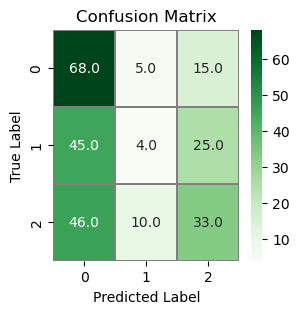

In [34]:
confusion_mtx = confusion_matrix(y_test, prob_ann_preds['ann_pred_result'])
f,ax = plt.subplots(figsize=(3,3))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [35]:
accuracy_score(y_test['result'],prob_ann_preds['ann_pred_result'])

0.41832669322709165

In [74]:
x_train, x_test, y_train, y_test = train_test_split(rf_df.loc[:,:'opp_xgoals_rf_proj'], rf_df[['result']], test_size=0.2)
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
rf_classifier = RandomForestClassifier(n_estimators=200, max_depth=2, random_state=0)
rf_classifier = CalibratedClassifierCV(rf_classifier, cv=5)
rf_classifier.fit(x_train, y_train)

/Users/masonlanger/env/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/masonlanger/env/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CalibratedClassifierCV(cv=5,
                       estimator=RandomForestClassifier(max_depth=2,
                                                        n_estimators=200,
                                                        random_state=0))

In [77]:
prob_rf_preds_proba = rf_classifier.predict_proba(x_test)
prob_rf_preds = pd.DataFrame(prob_rf_preds_proba, columns=['rf_prob_loss', 'rf_prob_tie','rf_prob_win'])
confusion_mtx = confusion_matrix(y_test, prob_rf_preds['rf_pred_result'])
f,ax = plt.subplots(figsize=(2,2))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

KeyError: 'rf_pred_result'

In [38]:
prob_rf_preds[prob_rf_preds['rf_prob_tie'] == max(prob_rf_preds['rf_prob_tie'])]

,rf_prob_loss,rf_prob_tie,rf_prob_win,rf_pred_result
16,0.325042,0.422448,0.25251,1


In [39]:
accuracy_score(y_test['result'],prob_rf_preds['rf_pred_result'])

0.4860557768924303

In [40]:
voting_df = pd.concat([prob_rf_preds, prob_ann_preds], axis=1)

In [41]:
voting_df['voting_prob_loss'] = (voting_df['rf_prob_loss']+voting_df['ann_prob_loss'])/2
voting_df['voting_prob_win'] = (voting_df['rf_prob_win']+voting_df['ann_prob_win'])/2
voting_df['voting_prob_tie'] = 1 - (voting_df['voting_prob_win']+voting_df['voting_prob_loss'])
voting_df

,rf_prob_loss,rf_prob_tie,rf_prob_win,rf_pred_result,ann_prob_loss,ann_prob_tie,ann_prob_win,ann_pred_result,voting_prob_loss,voting_prob_win,voting_prob_tie
0,0.609236,0.264839,0.125925,0,0.478753,0.292968,0.228280,0,0.543994,0.177102,0.278903
1,0.199283,0.315918,0.484799,3,0.219370,0.205739,0.574891,3,0.209326,0.529845,0.260829
2,0.350675,0.359363,0.289962,1,0.437196,0.366074,0.196730,0,0.393935,0.243346,0.362718
3,0.295858,0.329216,0.374926,3,0.305959,0.339710,0.354321,3,0.300908,0.364623,0.334468
4,0.393560,0.353553,0.252887,0,0.259792,0.277654,0.462553,3,0.326676,0.357720,0.315604
...,...,...,...,...,...,...,...,...,...,...,...
246,0.335062,0.352818,0.312120,1,0.390706,0.325491,0.283803,0,0.362884,0.297962,0.339155
247,0.560221,0.280073,0.159706,0,0.469687,0.277834,0.252479,0,0.514954,0.206093,0.278954
248,0.602846,0.269790,0.127364,0,0.429348,0.358629,0.212023,0,0.516097,0.169694,0.314210
249,0.270468,0.375254,0.354278,1,0.421116,0.299250,0.279397,0,0.345792,0.316838,0.337370


In [42]:
def categorize_voting_result(prob_loss, prob_win, prob_tie):
    proba = [prob_loss, prob_win, prob_tie]
    if max(proba) == prob_loss:
        return 0;
    elif max(proba) == prob_win:
        return 3;
    else:
        return 1;
voting_df['voting_pred_result'] = voting_df.apply(lambda x: categorize_voting_result(x.voting_prob_loss, x.voting_prob_win, x.voting_prob_tie), axis=1)
voting_df

,rf_prob_loss,rf_prob_tie,rf_prob_win,rf_pred_result,ann_prob_loss,ann_prob_tie,ann_prob_win,ann_pred_result,voting_prob_loss,voting_prob_win,voting_prob_tie,voting_pred_result
0,0.609236,0.264839,0.125925,0,0.478753,0.292968,0.228280,0,0.543994,0.177102,0.278903,0
1,0.199283,0.315918,0.484799,3,0.219370,0.205739,0.574891,3,0.209326,0.529845,0.260829,3
2,0.350675,0.359363,0.289962,1,0.437196,0.366074,0.196730,0,0.393935,0.243346,0.362718,0
3,0.295858,0.329216,0.374926,3,0.305959,0.339710,0.354321,3,0.300908,0.364623,0.334468,3
4,0.393560,0.353553,0.252887,0,0.259792,0.277654,0.462553,3,0.326676,0.357720,0.315604,3
...,...,...,...,...,...,...,...,...,...,...,...,...
246,0.335062,0.352818,0.312120,1,0.390706,0.325491,0.283803,0,0.362884,0.297962,0.339155,0
247,0.560221,0.280073,0.159706,0,0.469687,0.277834,0.252479,0,0.514954,0.206093,0.278954,0
248,0.602846,0.269790,0.127364,0,0.429348,0.358629,0.212023,0,0.516097,0.169694,0.314210,0
249,0.270468,0.375254,0.354278,1,0.421116,0.299250,0.279397,0,0.345792,0.316838,0.337370,0


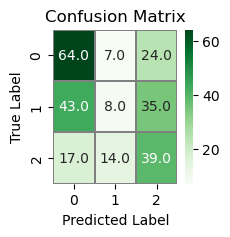

In [44]:
confusion_mtx = confusion_matrix(y_test['result'], voting_df['voting_pred_result'])
f,ax = plt.subplots(figsize=(2,2))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [43]:
accuracy_score(y_test['result'],voting_df['voting_pred_result'])

0.44223107569721115

In [70]:
xgb_classifier = xgboost.XGBClassifier(objective='multi:softprob', n_estimators=500, learning_rate=0.4, tree_method="exact", early_stopping_rounds=10)
# Fit the model to the training data
xgb_classifier.fit(x_train, y_train, eval_set=[(x_test, y_test)])
# Make predictions on the test set
xgb_preds_proba = xgb_classifier.predict_proba(x_test)
xgb_preds = xgb_classifier.predict(x_test)

[0]	validation_0-mlogloss:1.05416
[1]	validation_0-mlogloss:1.04141
[2]	validation_0-mlogloss:1.04039
[3]	validation_0-mlogloss:1.04196
[4]	validation_0-mlogloss:1.05074
[5]	validation_0-mlogloss:1.06274
[6]	validation_0-mlogloss:1.06867
[7]	validation_0-mlogloss:1.06820
[8]	validation_0-mlogloss:1.07218
[9]	validation_0-mlogloss:1.07417
[10]	validation_0-mlogloss:1.07606
[11]	validation_0-mlogloss:1.07599


In [71]:
xgb_preds_proba

array([[0.75275004, 0.12689589, 0.12035407],
       [0.20563743, 0.28003076, 0.5143318 ],
       [0.34449384, 0.42161444, 0.23389171],
       [0.20725356, 0.23454757, 0.55819887],
       [0.21608299, 0.3854685 , 0.39844853],
       [0.21386406, 0.27713066, 0.50900525],
       [0.40001306, 0.35296062, 0.24702634],
       [0.24946654, 0.40942383, 0.34110966],
       [0.72502244, 0.11765145, 0.15732613],
       [0.30916938, 0.45207968, 0.23875092],
       [0.35778806, 0.42026362, 0.22194831],
       [0.16694766, 0.21633516, 0.61671716],
       [0.45667702, 0.30248442, 0.24083857],
       [0.33403447, 0.19516437, 0.47080112],
       [0.30143434, 0.44076923, 0.2577964 ],
       [0.54996336, 0.31291875, 0.13711788],
       [0.30916938, 0.45207968, 0.23875092],
       [0.42063367, 0.27783135, 0.30153495],
       [0.30916938, 0.45207968, 0.23875092],
       [0.16841516, 0.2764025 , 0.5551824 ],
       [0.34757075, 0.36322716, 0.28920203],
       [0.2821963 , 0.38145003, 0.33635366],
       [0.

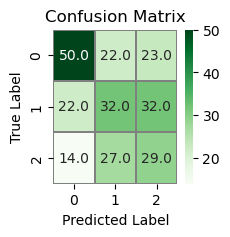

In [73]:
confusion_mtx = confusion_matrix(y_test, xgb_preds)
f,ax = plt.subplots(figsize=(2,2))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()